Sentiment Analysis of Amazon Reviews and Automated Response Generation

# 2. LLM affiné pour l'analyse des sentiments et les réponses contextuelles


#### **Aperçu**
Entraînez un LLM optimisé en termes de paramètres (par exemple, en utilisant LoRA ) pour classer les sentiments et générer des réponses contextuelles .



#### **Pourquoi ça convient ?**
Couvre le réglage fin, l'efficacité des paramètres (LoRA), l'architecture du transformateur, les intégrations, RAG, les techniques d'évaluation .



#### **Composants clés**
* Sélectionnez un LLM pré-entraîné (par exemple, distilBERT) et affinez-le pour la classification des sentiments (avis IMDB, données Twitter, etc.).
* Implémentez LoRA pour un réglage fin efficace des paramètres sur le processeur .
Utilisez des techniques de récupération (FAISS/Pinecone) pour des réponses contextuelles.
* Déployez une interface utilisateur Streamlit pour les interactions basées sur les sentiments.
* Évaluez les performances du modèle avec précision, perplexité, BLEU et ROUGE .
Bonus : Intégrez les flux de travail d’évaluation LLM aux mécanismes de rétroaction humaine .


#### **Considérations favorables au processeur**
*  **Modèles recommandés** : *distilBERT , BERT-base-uncased, roberta-small,albert-base-v2*
*  **Utilisation de la bibliothèque** : *transformers , optimum, peft,sentence-transformers*
*  **Conseils d'optimisation** :
  * Utiliser LoRA (Low-Rank Adaptation) au lieu d'un réglage fin complet
  * Réduire la taille de l'ensemble de données (par exemple, prendre seulement 10 000 échantillons de l'ensemble de données IMDB)
  * Utilisez des modèles de transformateurs plus petits ( distilBERTplus de BERT-base, albert-baseplus de BERT-large)
  * Utilisez la précision mixte ( fp16) si elle est prise en charge



In [1]:
# Install required packages
import subprocess

# Install core packages for Hugging Face models and training
command = [
    "pip", "install", "--upgrade",
    "datasets", "transformers", "peft", "accelerate", "bitsandbytes"
]

# Run the pip command silently
result = subprocess.run(command, capture_output=True, text=True)

# Show only the last 5 lines of the output
lines = result.stdout.strip().split("\n")
print("Last installation lines:\n")
print("\n".join(lines[-5:]))


Last installation lines:

  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [2]:
# Clean Torch installation for GPU compatibility
print(" - Uninstalling any existing torch packages...")
subprocess.run(["pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"],
               capture_output=True, text=True)

# Install compatible GPU version (Colab auto-detects the right one)
print(" - Installing torch (GPU version if available)...")
install_cmd = ["pip", "install", "--upgrade", "torch", "torchvision", "torchaudio"]
result = subprocess.run(install_cmd, capture_output=True, text=True)

print("\n - Last lines from torch installation:")
print("\n".join(result.stdout.strip().split("\n")[-5:]))


 - Uninstalling any existing torch packages...
 - Installing torch (GPU version if available)...

 - Last lines from torch installation:
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.1.9
    Uninstalling nvidia-cusolver-cu12-11.6.1.9:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.1.9


In [3]:
# Check torch version and path
import torch
print(torch.__file__)
print("Torch version:", torch.__version__)
print("Torch is working ")

/usr/local/lib/python3.11/dist-packages/torch/__init__.py
Torch version: 2.7.0+cu126
Torch is working 


In [4]:
# ============================
# Essential Libraries for BERT Sentiment Classification
# ============================

# Data manipulation
import pandas as pd
import numpy as np
import os
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class balancing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Deep learning with PyTorch
import torch.nn as nn
from torch.utils.data import Dataset

# Hugging Face Transformers
from transformers import (
    BertTokenizer,
    BertTokenizerFast,
    BertConfig,
    BertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# Hugging Face Datasets
from datasets import Dataset

# Hugging Face Hub login
from huggingface_hub import login
from getpass import getpass

# PEFT (LoRA fine-tuning)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel


In [10]:
# Move kaggle API key to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure file permissions

# Download and unzip the dataset
!kaggle datasets download -d halimedogan/amazon-reviews -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/halimedogan/amazon-reviews
License(s): unknown


In [11]:
# Check download success
print(os.listdir("/content"))

['.config', 'amazon_reviews.csv', 'sample_data']


In [12]:
# Load dataset using pandas
data = pd.read_csv("/content/amazon_reviews.csv")
data.shape

(4915, 12)

In [ ]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [ ]:
# Dataset overview
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB
None


In [ ]:
data["reviewerName"].values

array([nan, '0mie', '1K3', ..., 'Z S Liske', 'Z Taylor', 'Zza'],
      dtype=object)

In [ ]:
# Quick peek at the data (examples)
data["reviewText"][0]  # → "No issues"

'No issues.'

In [ ]:
data["reviewText"][1]  # → "Purchased this for my device, it worked as advertised..."

'Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.'

In [ ]:
# Check for missing values
print("Missing values in reviewText:", data['reviewText'].isna().sum())
print("Missing values in summary    :", data['summary'].isna().sum())

Missing values in reviewText: 1
Missing values in summary    : 0


In [ ]:
# Drop row with missing reviewText
data = data.dropna(subset=['reviewText']).reset_index(drop=True)

 ### Light Text Cleaning (for BERT compatibility)

In [ ]:
# Define a simple cleaning function suitable for BERT-like models
def light_clean(text):
    """
    Light text cleaning:
    - Lowercasing
    - Removing URLs
    - Trimming extra spaces
    This kind of preprocessing is aligned with the expectations of pre-trained models like BERT, DistilBERT, etc.
    """
    if pd.isna(text):
        return ""

    text = str(text).lower()                     # Lowercasing
    text = re.sub(r'http\S+', '', text)          # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()     # Normalize whitespace
    return text



In [ ]:
# Apply cleaning to 'reviewText' and 'summary'
data_cleaned = data.copy()

for col in ['reviewText', 'summary']:
    data_cleaned[f"clean_{col}"] = data_cleaned[col].fillna('').apply(light_clean)


In [ ]:
# Combine summary and full text into one field for classification
data_cleaned["clean_text"] = (
    data_cleaned['clean_summary'] + " " + data_cleaned['clean_reviewText']
)

### 📊 EDA – Target Distribution


In [ ]:
# Count number of reviews per 'overall' score
overall_counts = data_cleaned.groupby("overall")["reviewerID"].count().reset_index()
print(overall_counts)

   overall  reviewerID
0      1.0         244
1      2.0          80
2      3.0         142
3      4.0         527
4      5.0        3921


<ipython-input-21-3aa21a73fb5d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")


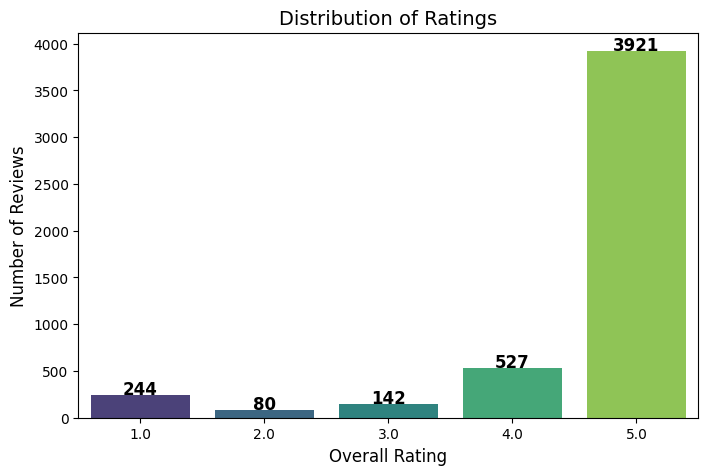

In [ ]:
# Barplot of score distribution
import matplotlib.pyplot as plt
import seaborn as sns

counts = data_cleaned["overall"].value_counts().sort_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")

for i, v in enumerate(counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12, fontweight='bold')

plt.xlabel("Overall Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.title("Distribution of Ratings", fontsize=14)
plt.show()

### 🎯 Sentiment Classification Setup

In [ ]:
# Remove neutral reviews (score = 3)
data_cleaned = data_cleaned[data_cleaned['overall'] != 3]

# Create binary sentiment label
data_cleaned['label'] = data_cleaned['overall'].apply(lambda x: 1 if x > 3 else 0)



<ipython-input-22-07619078a3ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['label'] = data_cleaned['overall'].apply(lambda x: 1 if x > 3 else 0)


<ipython-input-23-8930c130f5fa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_cleaned["label"], palette=["red", "green"])


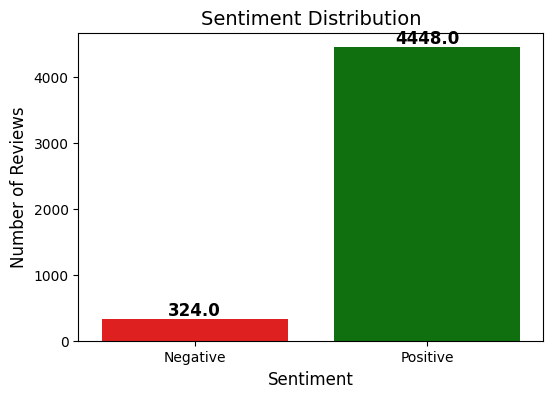

In [ ]:
# Visualize class distribution (positive vs negative)
plt.figure(figsize=(6,4))
ax = sns.countplot(x=data_cleaned["label"], palette=["red", "green"])

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.title("Sentiment Distribution", fontsize=14)
plt.show()

In [ ]:
# Final dataset with clean text and label
df = data_cleaned[["reviewerID", "clean_text", "label"]].copy()
df["sentiment"] = df["label"].apply(lambda x: "positive" if x == 1 else "negative")

print("Final DataFrame shape (reviewerID, clean_text, label):", df.shape)
df.sample(5)


Final DataFrame shape (reviewerID, clean_text, label): (4772, 4)


,reviewerID,clean_text,label,sentiment
1307,A2OUWRUD08N12X,ultra microsdhc good price and fast enough to ...,1,positive
4222,A89V803G3X0WQ,i got a rock the 64gb card i purchased actuall...,0,negative
2639,A16UBZOIW2OJG5,very unethical to claim 30mb/s. false advertis...,0,negative
2510,A13U0SK7CCMNVH,does the job i've had good luck with sandisk c...,1,positive
76,A1LP4NB5X34HF8,"128 gb and 64 gb versions great, but can't con...",1,positive


### 📏 Text Length Analysis

In [ ]:
# Add word count per review
data_cleaned["text_length"] = data_cleaned["clean_text"].apply(lambda x: len(str(x).split()))

# Summary statistics
print(" > Text length statistics:\n")
print(" > Mean     :", data_cleaned["text_length"].mean())
print(" > Median   :", data_cleaned["text_length"].median())
print(" > Min      :", data_cleaned["text_length"].min())
print(" > Max      :", data_cleaned["text_length"].max())
print(" > Std Dev  :", data_cleaned["text_length"].std())

 > Text length statistics:

 > Mean     : 54.1219614417435
 > Median   : 37.0
 > Min      : 2
 > Max      : 1579
 > Std Dev  : 59.48566847059569


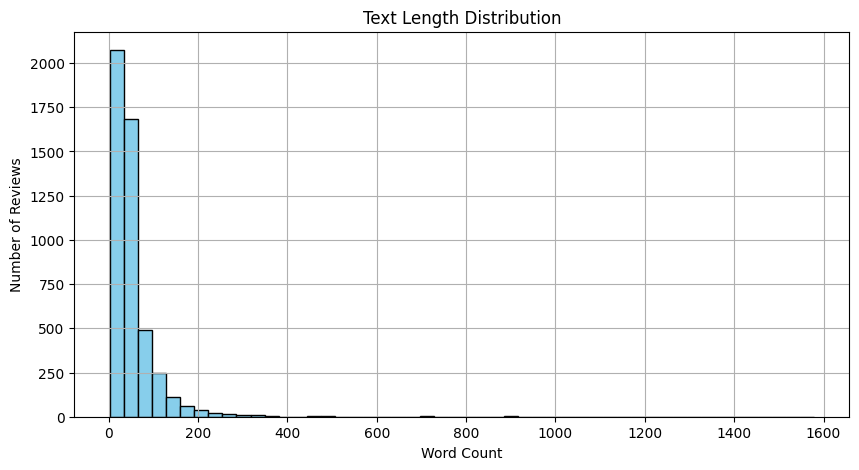

In [ ]:
# Histogram of text lengths
plt.figure(figsize=(10, 5))
plt.hist(data_cleaned["text_length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()



### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data while keeping class distribution consistent
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [ ]:
# Wrap splits into dataframes
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})
print(train_df.shape)
print(test_df.shape)

(3817, 2)
(955, 2)


### Class Weights & Tokenization

In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=df['label']
)

# Convert to PyTorch tensor for use in the loss function
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)


Class weights: tensor([7.3642, 0.5364])


### Convert to Hugging Face Dataset Format



In [ ]:
# Convert pandas DataFrames to Hugging Face Dataset objects
# Required for using the Trainer API
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

### Hugging Face Authentication (for model upload)


In [ ]:
from getpass import getpass
from huggingface_hub import login

# Secure login with personal token
huggingface_token = getpass("Enter your Hugging Face token: ")
os.environ["HUGGING_FACE_HUB_TOKEN"] = huggingface_token
login(token=huggingface_token)

Enter your Hugging Face token: ··········


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Tokenization

In [ ]:
from transformers import BertTokenizer

# Load the tokenizer of the chosen model (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 128

# Define tokenization function for Hugging Face Datasets
def tokenize_function(example):
    return tokenizer(example["text"],
                     padding="max_length",
                     truncation=True,
                     max_length=max_length)

# Apply the tokenizer to both datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3817 [00:00<?, ? examples/s]

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

###Classic Fine-Tuning with Weighted Loss (No LoRA)

#### Define a Custom BERT Model with Weighted Loss

In [ ]:
# This custom class adds class weights support to the standard BERT classification head
class BertWithWeightedLoss(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Forward call to BERT base class
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        logits = outputs.logits

        # Apply custom weighted loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

 #### Load Model Configuration and Instantiate Custom Model

In [ ]:
# Load the BERT config
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)

# Instantiate the custom model with class weights
model = BertWithWeightedLoss.from_pretrained(
    "bert-base-uncased",
    config=config,
    class_weights=class_weights
)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Arguments

In [ ]:
from transformers import TrainingArguments

# Define the training configuration for the Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./results",                 # Directory to save checkpoints
    evaluation_strategy="epoch",            # Evaluate at the end of each epoch
    save_strategy="epoch",                  # Save model at the end of each epoch
    logging_strategy="epoch",               # Log metrics at each epoch
    num_train_epochs=3,                     # Number of training epochs
    per_device_train_batch_size=8,          # Training batch size per device
    per_device_eval_batch_size=16,          # Eval batch size per device
    warmup_steps=0,                         # Warm-up steps for learning rate scheduler
    weight_decay=0.01,                      # L2 regularization to reduce overfitting
    logging_dir="./logs",                   # Directory to store log files
    load_best_model_at_end=True,            # Automatically load best checkpoint (by metric)
    metric_for_best_model="f1",             # Use f1_score to track best model
    report_to="none"                        # Avoid sending logs to external tools
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Define Custom Metrics

In [ ]:
# Compute standard classification metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Convert logits to predicted class

    # Compute precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

###  Metric Selection: We will use F1-Score

In this binary sentiment classification task, we are dealing with **imbalanced classes**: most of the reviews are **positive**, and fewer are **negative**.

Using **accuracy** alone can be misleading, since a model that predicts "positive" all the time may still achieve high accuracy but fail to detect negative reviews.

To address this, we choose the **F1-score** as our main evaluation metric.  
It provides a **balanced trade-off** between **precision** (avoiding false positives) and **recall** (avoiding false negatives), which is essential for this kind of task.


### Train with Hugging Face Trainer

In [ ]:
# Hugging Face Trainer takes care of training, evaluation, logging, saving
trainer = Trainer(
    model=model,                            # Our custom weighted model
    args=training_args,                     # Training config
    train_dataset=tokenized_train,          # Tokenized training dataset
    eval_dataset=tokenized_test,            # Tokenized evaluation dataset
    tokenizer=tokenizer,                    # Tokenizer used for preprocessing
    compute_metrics=compute_metrics         # Custom evaluation metrics
)


<ipython-input-52-db5d3ad667f6>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Start the training process and monitor progress
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.135000,0.744245,0.979058,0.988864,0.980132,0.997753
2,0.031400,0.407234,0.981152,0.989865,0.992099,0.987640
3,0.001800,0.591394,0.984293,0.991597,0.988827,0.994382


TrainOutput(global_step=1434, training_loss=0.05607624316647794, metrics={'train_runtime': 332.5703, 'train_samples_per_second': 34.432, 'train_steps_per_second': 4.312, 'total_flos': 753221173731840.0, 'train_loss': 0.05607624316647794, 'epoch': 3.0})

In [ ]:
# Show which step/checkpoint was considered the best (F1-wise)
print("Best metric:", trainer.state.best_metric)
print("Best model checkpoint path:", trainer.state.best_model_checkpoint)

Best metric: 0.9915966386554622
Best model checkpoint path: ./results/checkpoint-1434


In [ ]:
# Extract the epoch number from the checkpoint folder name
checkpoint_path = trainer.state.best_model_checkpoint

# Extract step number from checkpoint path (e.g., "./results/checkpoint-187")
match = re.search(r"checkpoint-(\d+)", checkpoint_path)
if match:
    best_step = int(match.group(1))
    print("Best step:", best_step)
else:
    print("Unable to determine step from checkpoint path.")


Best step: 1434


In [ ]:
# Nombre total d'exemples d'entraînement
num_train_samples = len(tokenized_train)

# Taille des batchs
batch_size = training_args.per_device_train_batch_size

# Nombre de steps par epoch
steps_per_epoch = num_train_samples // batch_size
print("Steps per epoch:", steps_per_epoch)


Steps per epoch: 477


In [ ]:
best_epoch_approx = best_step / steps_per_epoch
print(f"Best model ≈ epoch {best_epoch_approx:.2f}")


Best model ≈ epoch 3.01


### Training Analysis – Full Fine-Tuning (Best Model at Epoch 3)

We now visualize the training and validation curves for the best model obtained using full fine-tuning.

This model was selected based on the **highest F1-score**, and it corresponds to approximately **epoch 3.0**.  
We plot both the **training and validation losses**, as well as the **validation F1-score** to observe the model's performance and stability.


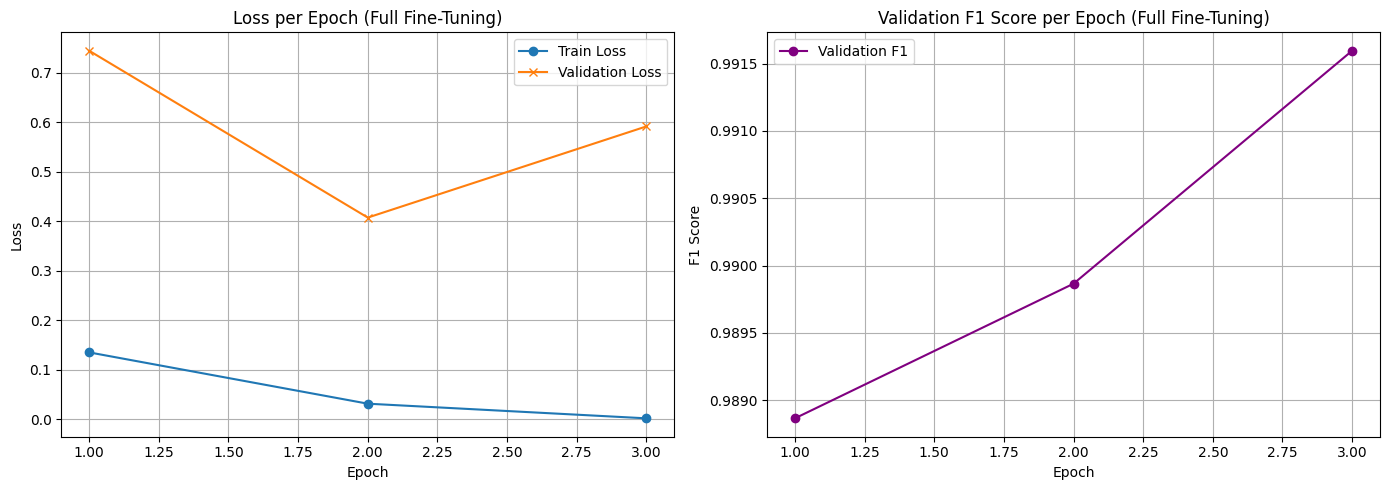

In [ ]:
# Plot Train Loss, Validation Loss, and Validation F1 for the best full fine-tuned model

# Retrieve training logs (filtered up to epoch 3)
logs = trainer.state.log_history
logs = [log for log in logs if "epoch" in log and log["epoch"] <= 3.0]

# Extract training and evaluation metrics
train_epochs = [log["epoch"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_epochs = [log["epoch"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_f1s = [log["eval_f1"] for log in logs if "eval_f1" in log]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker='x')
plt.title("Loss per Epoch (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# F1 Score Curve
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1s, label="Validation F1", marker='o', color='purple')
plt.title("Validation F1 Score per Epoch (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Fine-Tuning with LoRA (Parameter-Efficient)

In [ ]:
# Reload the base model (unmodified) for LoRA training
base_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define LoRA config for sequence classification
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,    # Task: sequence classification
    r=4,                           # Rank (low-rank decomposition)
    lora_alpha=8,                  # Scaling factor
    lora_dropout=0.1,              # Dropout for regularization
    bias="lora_only"               # Only apply LoRA to bias layers
)

# Apply LoRA to the base model
lora_model = get_peft_model(base_model, lora_config)

# Check number of trainable parameters
lora_model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 167,426 || all params: 109,632,772 || trainable%: 0.1527


In [ ]:
# Retrain using the same Trainer API, but with the LoRA-augmented model
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-62-113d28d88100>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.269500,0.242606,0.931937,0.964770,0.931937,1.000000
2,0.203400,0.195084,0.932984,0.965255,0.933824,0.998876
3,0.164900,0.168067,0.938220,0.967812,0.940615,0.996629


TrainOutput(global_step=1434, training_loss=0.2126196963683997, metrics={'train_runtime': 200.3856, 'train_samples_per_second': 57.145, 'train_steps_per_second': 7.156, 'total_flos': 754531481797632.0, 'train_loss': 0.2126196963683997, 'epoch': 3.0})

#### Compare Fine-Tuning Strategies

In [ ]:
# Simple performance comparison between Full Fine-tuning and LoRA
data = {
    "Metric": [
        "Accuracy max",
        "F1 max",
        "Training time (sec)",
        "Training loss final",
        "Validation loss final"
    ],
    "Full Fine-tuning": [
        0.9822,
        0.9905,
        339,
        0.0739,
        0.4286
    ],
    "LoRA": [
        0.9382,
        0.9678,
        202,
        0.1649,
        0.1681
    ]
}

df_comparison = pd.DataFrame(data).set_index("Metric")
df_comparison.head()

,Full Fine-tuning,LoRA
Metric,,
Accuracy max,0.9822,0.9382
F1 max,0.9905,0.9678
Training time (sec),339.0000,202.0000
Training loss final,0.0739,0.1649
Validation loss final,0.4286,0.1681


In [ ]:
# Get best checkpoint path for LoRA
lora_best_checkpoint = trainer.state.best_model_checkpoint
print("🔎 Best LoRA model checkpoint path:", lora_best_checkpoint)

# Extract step
match = re.search(r"checkpoint-(\d+)", lora_best_checkpoint)
if match:
    lora_best_step = int(match.group(1))
    print("Best step (LoRA):", lora_best_step)


🔎 Best LoRA model checkpoint path: ./results/checkpoint-1434
Best step (LoRA): 1434


In [ ]:
# Define your save path
save_path = "./app/bert_sentiment_lora"

# Save LoRA adapters
lora_model.save_pretrained(save_path)

# Save tokenizer (same tokenizer as before)
tokenizer.save_pretrained(save_path)

print(f"LoRA model and tokenizer saved to {save_path}")


LoRA model and tokenizer saved to ./app/bert_sentiment_lora


### Save Final Model for Reuse (LoRA)

In [ ]:
from peft import PeftModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Function to load LoRA fine-tuned model and tokenizer
def load_classification_model():
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model = PeftModel.from_pretrained(base_model, "app/bert_sentiment_lora")
    tokenizer = AutoTokenizer.from_pretrained("app/bert_sentiment_lora")
    model.eval()
    return tokenizer, model

# Load model (to be reused in Notebook 2 or Streamlit)
cls_tokenizer, cls_model = load_classification_model()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Model is ready for inference")
inputs = cls_tokenizer("Great product, fast delivery!", return_tensors="pt")
with torch.no_grad():
    outputs = cls_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    print("Predicted probabilities:", probs)

Model is ready for inference
Predicted probabilities: tensor([[0.0022, 0.9978]])


### Inference Check – LoRA Model

The model has been successfully loaded using the base BERT architecture combined with the LoRA adapters.

We tested it on a simple sentence and verified that it produces a valid output, meaning the LoRA weights were correctly applied.

This confirms that the model is now ready for:
- Use in downstream tasks (in our case,  response generation)
- Integration into a web application via Streamlit


### 📊 Training Analysis – LoRA Fine-Tuning (Best Model)

We now plot the training and validation curves for the best model obtained using LoRA fine-tuning.

As before, the model was selected based on the highest **F1-score**. We visualize both the **training and validation losses**, as well as the **validation F1-score** over the 3 training epochs.


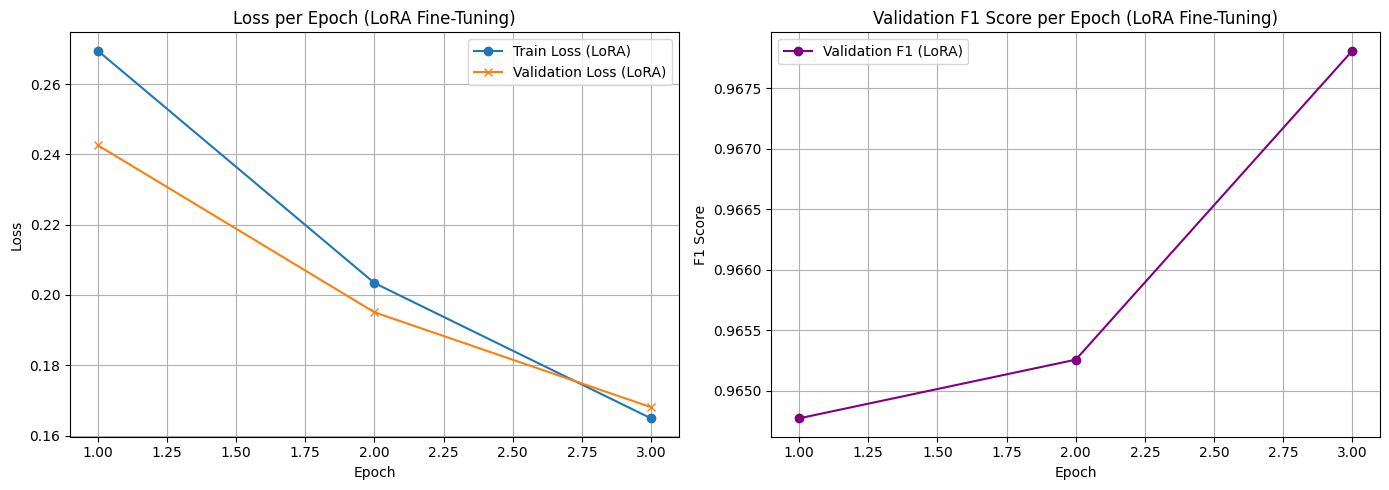

In [ ]:
# 📊 Plot training & validation loss + validation F1 for LoRA model

# Retrieve logs after LoRA fine-tuning
lora_logs = trainer.state.log_history
lora_logs = [log for log in lora_logs if "epoch" in log and log["epoch"] <= 3.0]

# Extract metrics
lora_train_epochs = [log["epoch"] for log in lora_logs if "loss" in log and "eval_loss" not in log]
lora_train_losses = [log["loss"] for log in lora_logs if "loss" in log and "eval_loss" not in log]

lora_eval_epochs = [log["epoch"] for log in lora_logs if "eval_loss" in log]
lora_eval_losses = [log["eval_loss"] for log in lora_logs if "eval_loss" in log]
lora_eval_f1s = [log["eval_f1"] for log in lora_logs if "eval_f1" in log]

# Plotting
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(lora_train_epochs, lora_train_losses, label="Train Loss (LoRA)", marker='o')
plt.plot(lora_eval_epochs, lora_eval_losses, label="Validation Loss (LoRA)", marker='x')
plt.title("Loss per Epoch (LoRA Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# F1
plt.subplot(1, 2, 2)
plt.plot(lora_eval_epochs, lora_eval_f1s, label="Validation F1 (LoRA)", marker='o', color='purple')
plt.title("Validation F1 Score per Epoch (LoRA Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Model Selection Justification

Based on the training curves, both models show good performance, but with different dynamics:

- The **full fine-tuning** model achieved slightly higher F1 and accuracy scores overall. However, its **validation loss decreased and then increased**, which may indicate the beginning of overfitting.
- In contrast, the **LoRA fine-tuned model** showed a **consistently decreasing loss** on both training and validation sets, and its **F1-score steadily increased** over the epochs.

Despite having slightly lower peak performance, the LoRA model demonstrates **better generalization stability** and a **lighter memory footprint**, which makes it more suitable for deployment.

We therefore choose the **LoRA model** as our final model for inference and response generation.


## Saving Results and Final Model

To use our classifier in the next phase (response generation and app interface), we save:

- A CSV file containing the test texts, true labels, and predicted sentiments.
- The LoRA fine-tuned model and tokenizer, ready to be reloaded and used for inference.

This ensures that the model is easily portable across notebooks and applications.


#### Save test_with_predictions.csv

In [ ]:
import shutil
# Generate predictions on test set
predictions = trainer.predict(tokenized_test)
predicted_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
predicted_labels = predicted_probs.argmax(dim=1).numpy()

# Recreate the test texts from the original dataframe
test_df_with_texts = test_df.copy()
test_df_with_texts["predicted_label"] = predicted_labels
test_df_with_texts["predicted_sentiment"] = test_df_with_texts["predicted_label"].apply(lambda x: "positive" if x == 1 else "negative")

# Save directly into app/ folder
output_path = "app/test_with_predictions.csv"
test_df_with_texts.to_csv(output_path, index=False)

print(f" test_with_predictions.csv saved to {output_path}")


 test_with_predictions.csv saved to app/test_with_predictions.csv


#### Save LoRA model and tokenizer (local folder)

In [ ]:
# Define path
save_path = "./app/bert_sentiment_lora"

# Save model
lora_model.save_pretrained(save_path)

# Save tokenizer
tokenizer.save_pretrained(save_path)

print(f" LoRA model and tokenizer saved to {save_path}")


 LoRA model and tokenizer saved to ./app/bert_sentiment_lora


In [ ]:
# Compress the entire 'app/' directory into a single ZIP file
shutil.make_archive("bert_sentiment_package", format="zip", root_dir="app")

print("All files in 'app/' have been compressed into 'bert_sentiment_package.zip'")

All files in 'app/' have been compressed into 'bert_sentiment_package.zip'


In [ ]:
from google.colab import files
files.download("bert_sentiment_package.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>